## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/ct-ch4-monthgrid-v2023_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [STAC Terminology](#stac-terminology)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Fetch Imagery from Raster API](#fetch-imagery-from-raster-api)
- [Generate Map](#generate-map)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 1° x 1°
- **Temporal extent**: January 1998 - December 2021
- **Temporal resolution**: Monthly
- **Unit**: Grams of methane per square meter per year
- **Utility**: Climate Research

For more, visit the [CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes](https://earth.gov/ghgcenter/data-catalog/ct-ch4-monthgrid-v2023) data overview page.  

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes Data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data
#### CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes
Surface methane (CH₄) emissions are derived from atmospheric measurements of methane and its ¹³C carbon isotope content. Different sources of methane contain different ratios of the two stable isotopologues, ¹²CH₄ and ¹³CH₄. This makes normally indistinguishable collocated sources of methane, say from agriculture and oil and gas exploration, distinguishable. The National Oceanic and Atmospheric Administration (NOAA) collects whole air samples from its global cooperative network of flasks (https://gml.noaa.gov/ccgg/about.html), which are then analyzed for methane and other trace gasses. A subset of those flasks are also analyzed for ¹³C of methane in collaboration with the Institute of Arctic and Alpine Research at the University of Colorado Boulder. Scientists at the National Aeronautics and Space Administration (NASA) and NOAA used those measurements of methane and ¹³C of methane in conjunction with a model of atmospheric circulation to estimate emissions of methane separated by three source types, microbial, fossil and pyrogenic.

For more information regarding this dataset, please visit the [CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes](https://earth.gov/ghgcenter/data-catalog/ct-ch4-monthgrid-v2023) data overview page.

## STAC Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes
- `item`:       One granule in the dataset, e.g. one monthly file of methane inverse fluxes
- `asset`:      A variable available within the granule, e.g. microbial, fossil, or pyrogenic methane fluxes
- `STAC API`:   Endpoint for fetching the data itself
- `Raster API`: Endpoint for fetching data **imagery**

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import JSON
from stats_module import generate_stats, clean_stats, display_stats

# Query the STAC API
First, we are going to import the required libraries. Once imported, they allow better executing a query in the GHG Center Spatio Temporal Asset Catalog (STAC) Application Programming Interface (API) where the granules for this collection are stored.

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# The collection name is used to fetch the dataset from the STAC API. First, we define the collection name as a variable
# Name of the collection for CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes 
collection_name = "ct-ch4-monthgrid-v2023"

In [3]:
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac_client' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=ct-ch4-monthgrid-v2023>

In [4]:
# Next, we need to specify the asset name for this collection
# The asset name is referring to the raster band containing the pixel values for the parameter of interest
# For this notebook, we'll focus on microbial sources of CH4 fluxes, so our asset of interest is:
asset_name = "microbial"

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 1998 to December 2021. By looking at the `dashboard:time density`, we observe that the data is periodic with monthly time density.

In [5]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 288 items


In [6]:
search = catalog.search(
    collections=collection_name,
    datetime=['2010-01-01T00:00:00Z','2010-12-31T00:00:00Z']
)
# Take a look at the items we found
for item in search.item_collection():
    print(item)

<Item id=ct-ch4-monthgrid-v2023-201012>
<Item id=ct-ch4-monthgrid-v2023-201011>
<Item id=ct-ch4-monthgrid-v2023-201010>
<Item id=ct-ch4-monthgrid-v2023-201009>
<Item id=ct-ch4-monthgrid-v2023-201008>
<Item id=ct-ch4-monthgrid-v2023-201007>
<Item id=ct-ch4-monthgrid-v2023-201006>
<Item id=ct-ch4-monthgrid-v2023-201005>
<Item id=ct-ch4-monthgrid-v2023-201004>
<Item id=ct-ch4-monthgrid-v2023-201003>
<Item id=ct-ch4-monthgrid-v2023-201002>
<Item id=ct-ch4-monthgrid-v2023-201001>


In [7]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=ct-ch4-monthgrid-v2023-202112>

# Creating Maps using Folium
You will now explore changes in the microbial CH₄ flux for two different dates. You will visualize the outputs on a map using `folium`.

## Fetch Imagery from Raster API
Here we get information from the `Raster API` which we will add to our map in the next section.

In [8]:
# To access the year value from each item more easily, this will let us query more explicitly by year and month (e.g., 2020-02)
items_dict = {item.properties["start_datetime"][:7]: item for item in collection.get_items()}

In [9]:
# Choose a color for displaying the tiles
# Please refer to matplotlib library if you'd prefer choosing a different color ramp.
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html

color_map = "purd"

In [10]:
# Specify which two date/times you would like to visualize, using the format of items_dict.keys()
dates = ["2021-07","2021-01"]

Below, we use some statistics of the raster data to set upper and lower limits for our color bar. These are saved as the `rescale_values`, and will be passed to the Raster API in the following step(s).

In [11]:
# Extract collection name and item ID for the first date
observation_date_1 = items_dict[dates[0]]
collection_id = observation_date_1.collection_id
item_id = observation_date_1.id
# Select relevant asset (microbial CH4 emissions)
object = observation_date_1.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Print the raster bands' information
raster_bands

[{'scale': 1.0,
  'nodata': -9999.0,
  'offset': 0.0,
  'sampling': 'area',
  'data_type': 'float64',
  'histogram': {'max': 267.10247712139517,
   'min': 0.0,
   'count': 11,
   'buckets': [64301, 381, 72, 26, 13, 2, 1, 0, 2, 2]},
  'statistics': {'mean': 1.0617093134900923,
   'stddev': 5.465988434405864,
   'maximum': 267.10247712139517,
   'minimum': 0.0,
   'valid_percent': 100.0}}]

In [12]:
# Use mean, scaled stddev, and minimum to generate an appropriate color bar range.
rescale_values = {
    "max": raster_bands[0]['statistics']['mean'] + 2.5*raster_bands[0]['statistics']['stddev'],
    "min": raster_bands[0]['statistics']['minimum'],
}

print(rescale_values)

{'max': 14.726680399504753, 'min': 0.0}


Now, you will pass the item id, collection name, asset name, and the `rescaling factor` to the `Raster API` endpoint. This step is done twice, one for each date/time you will visualize. This step tells the Raster API which collection, item, and asset you want to view, and specifies the colormap and colorbar ranges to use for visualization. The API returns a JSON with information about the requested image. Each image will be referred to as a `tile`.

In [13]:
# Make a GET request to retrieve information for your first date/time
observation_date_1_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
observation_date_1_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/ct-ch4-monthgrid-v2023/items/ct-ch4-monthgrid-v2023-202107/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=microbial&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C14.726680399504753'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [14]:
# Repeat the above for your second date/time
# Note that we do not calculate new rescale_values for this tile, because we dates tiles 1 and 2 to have the same colorbar range for best visual comparison.
observation_date_2 = items_dict[dates[1]]
# Extract collection name and item ID
collection_id = observation_date_2.collection_id
item_id = observation_date_2.id

observation_date_2_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
observation_date_2_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/ct-ch4-monthgrid-v2023/items/ct-ch4-monthgrid-v2023-202101/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=microbial&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C14.726680399504753'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Generate Map
First, we'll define the Area of Interest (AOI) as a GEOJSON. This will be visualized as a filled polygon on the map.

In [15]:
# The AOI is currently set to Eastern Cananda, North America.
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            # [longitude, latitude]
            [-106.81091327586626,58.13717287115446],  # Southwest Bounding Coordinate
            [-106.81091327586626,46.689085955377266], # Southeast Bounding Coordinate
            [-84.5565048510494,46.689085955377266],   # Northeast Bounding Coordinate
            [-84.5565048510494,58.13717287115446],    # Northwest Bounding Coordinate
            [-106.81091327586626,58.13717287115446]   # Closing the polygon at the Southwest Bounding Coordinate
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

We will use the `DualMap` format from `folium` to visualize our two dates side-by-side for the area of interest. Below we add the desired layers to our map and add markers to identify the date/times shown.

In [16]:
# Initialize the map, specifying the center of the map and the starting zoom level.
# 'folium.plugins' allows mapping side-by-side via 'DualMap'
# You can change the center location of the map by changing the "center_latlon = (LAT,LON)" statement.
center_latlon = (52, -95.3)
map_ = folium.plugins.DualMap(location=center_latlon, zoom_start=4)


# Define the first map layer using the tile fetched for the first date
# The TileLayer library helps in manipulating and displaying raster layers on a map
map_layer_observation_date_1 = TileLayer(
    tiles=observation_date_1_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the first layer to the Dual Map
# This will appear on the left side, specified by 'm1'
map_layer_observation_date_1.add_to(map_.m1)


# Define the second map layer using the tile fetched for the second date
map_layer_observation_date_2 = TileLayer(
    tiles=observation_date_2_tile["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.8, # Adjust the transparency of the layer
)
# Add the second layer to the Dual Map
# This will appear on the right side, specified by 'm2'
map_layer_observation_date_2.add_to(map_.m2)

# Display AOI on both maps
folium.GeoJson(aoi, name="Eastern Canada, North America").add_to(map_)

# Visualize the Dual Map
map_

This visualization effectively illustrates the difference in microbial activity in warm vs. cold temperatures, which vary most widely at high latitudes.

# Calculate Zonal Statistics
To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Eastern Canada, North America.

In [17]:
# Give your AOI a name to be used in your time series plot later on.
aoi_name='Eastern Canada'
# This AOI is defined as a GEOJSON.
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            # [longitude, latitude]
            [-106.81091327586626,58.13717287115446],  # Southwest Bounding Coordinate
            [-106.81091327586626,46.689085955377266], # Southeast Bounding Coordinate
            [-84.5565048510494,46.689085955377266],   # Northeast Bounding Coordinate
            [-84.5565048510494,58.13717287115446],    # Northwest Bounding Coordinate
            [-106.81091327586626,58.13717287115446]   # Closing the polygon at the Southwest Bounding Coordinate
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

Before we generate stats for a specific item (observation), we first check the total number of items available within the collection and retrieve the information regarding their start datetime.

In [18]:
# Check total number of items available within the collection
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]

# Print the total number of items (granules) found
print(f"Found {len(items)} items")

Found 288 items


In [19]:
# Examine the first item in the collection
items[0]

{'id': 'ct-ch4-monthgrid-v2023-202112',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/ct-ch4-monthgrid-v2023'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/ct-ch4-monthgrid-v2023'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://earth.gov/ghgcenter/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://earth.gov/ghgcenter/api/stac/collections/ct-ch4-monthgrid-v2023/items/ct-ch4-monthgrid-v2023-202112'},
  {'title': 'Map of Item',
   'href': 'https://earth.gov/ghgcenter/api/raster/collections/ct-ch4-monthgrid-v2023/items/ct-ch4-monthgrid-v2023-202112/map?assets=total&rescale=0%2C50&colormap_name=purd',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets': {'total': {'href': 's3://ghgc-data-store/ct-ch4-monthgrid-v2023/CTCH4_meth

Now that we created the polygon for the area of interest, we need to develop a function that runs through the data collection and generates the statistics for a specific item (granule) within the boundaries of the AOI polygon.

In [25]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# Create a function that retrieves information regarding a specific granule using its asset name and raster identifier and generates the statistics for it

# The function takes an item (granule) and a JSON (polygon) as input parameters
def generate_stats(item, geojson):

    # A POST request is made to submit the data associated with the item of interest (specific observation) within the boundaries of the polygon to compute its statistics
    result = requests.post(

        # Raster API Endpoint for computing statistics
        f"{RASTER_API_URL}/cog/statistics",

        # Pass the URL to the item, asset name, and raster identifier as parameters
        params={"url": item["assets"][asset_name]["href"]},

        # Send the GeoJSON object (polygon) along with the request
        json=geojson,

    # Return the response in JSON format
    ).json()["features"][0]

    # Print the result
    print(result)

    # Return a dictionary containing the computed statistics along with the item's datetime information.
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"][:10],
    }

In [26]:
# Generate a for loop that iterates over all the existing items in the collection
for item in items:

    # The loop will then retrieve the information for the start datetime of each item in the list
    print(item["properties"]["start_datetime"][:10])

    # Exit the loop after printing the start datetime for the first item in the collection
    break

2021-12-01


Generate the statistics for the AOI

In [28]:
%%time
# %%time = Wall time (execution time) for running the code below

# Generate statistics using the created function "generate_stats" within the bounding box defined by the polygon
stats = [generate_stats(item, aoi) for item in items]

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-106.81091327586626, 58.13717287115446], [-106.81091327586626, 46.689085955377266], [-84.5565048510494, 46.689085955377266], [-84.5565048510494, 58.13717287115446], [-106.81091327586626, 58.13717287115446]]]}, 'properties': {'statistics': {'b1': {'min': 0.0, 'max': 5.108452536076932, 'mean': 0.4624914437653177, 'count': 259.8399963378906, 'sum': 120.1737750542859, 'std': 0.6810670308458714, 'median': 0.14465238545483125, 'majority': 0.0, 'minority': 4.037977995927961e-10, 'unique': 284.0, 'histogram': [[215, 31, 30, 16, 3, 1, 1, 1, 0, 1], [0.0, 0.5108452536076932, 1.0216905072153863, 1.5325357608230794, 2.0433810144307727, 2.554226268038466, 3.065071521646159, 3.575916775253852, 4.086762028861545, 4.597607282469238, 5.108452536076932]], 'valid_percent': 100.0, 'masked_pixels': 0.0, 'valid_pixels': 299.0, 'percentile_2': 0.0, 'percentile_98': 2.144741435811218}}}}
{'type': 'Feature', 'geometry': {'type': 'Polygon', 'c

Create a function that goes through every single item in the collection and populates their properties - including the minimum, maximum, and sum of their values - in a table.

In [29]:
# Print the stats for the first item in the collection
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 5.108452536076932,
   'mean': 0.4624914437653177,
   'count': 259.8399963378906,
   'sum': 120.1737750542859,
   'std': 0.6810670308458714,
   'median': 0.14465238545483125,
   'majority': 0.0,
   'minority': 4.037977995927961e-10,
   'unique': 284.0,
   'histogram': [[215, 31, 30, 16, 3, 1, 1, 1, 0, 1],
    [0.0,
     0.5108452536076932,
     1.0216905072153863,
     1.5325357608230794,
     2.0433810144307727,
     2.554226268038466,
     3.065071521646159,
     3.575916775253852,
     4.086762028861545,
     4.597607282469238,
     5.108452536076932]],
   'valid_percent': 100.0,
   'masked_pixels': 0.0,
   'valid_pixels': 299.0,
   'percentile_2': 0.0,
   'percentile_98': 2.144741435811218}},
 'datetime': '2021-12-01'}

In [31]:
# Apply the generated function on the stats data
df = clean_stats(stats)

# Display the stats for the first 5 granules in the collection in the table
# Change the value in the parenthesis to show more or a smaller number of rows in the table
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2021-12-01,0.0,5.108453,0.462491,259.839996,120.173775,0.681067,0.144652,0.0,4.037978e-10,284.0,"[[215, 31, 30, 16, 3, 1, 1, 1, 0, 1], [0.0, 0....",100.0,0.0,299.0,0.0,2.144741,2021-12-01
1,2021-11-01,0.0,8.948744,0.489566,259.839996,127.208785,0.822334,0.154946,0.0,4.022754e-10,284.0,"[[234, 50, 8, 2, 2, 1, 0, 0, 0, 2], [0.0, 0.89...",100.0,0.0,299.0,0.0,2.749251,2021-11-01
2,2021-10-01,0.0,16.483715,1.120935,259.839996,291.263764,2.369823,0.250249,0.0,3.991959e-10,284.0,"[[257, 18, 8, 4, 4, 2, 0, 4, 0, 2], [0.0, 1.64...",100.0,0.0,299.0,0.0,9.674084,2021-10-01
3,2021-09-01,0.0,41.986603,4.998134,259.839996,1298.715028,7.781834,1.080674,0.0,3.846915e-10,284.0,"[[211, 26, 18, 18, 7, 7, 4, 4, 2, 2], [0.0, 4....",100.0,0.0,299.0,0.0,31.233282,2021-09-01
4,2021-08-01,0.0,90.033589,12.899867,259.839996,3351.901356,17.147098,1.283863,0.0,3.684496e-10,284.0,"[[177, 30, 31, 27, 17, 5, 8, 2, 0, 2], [0.0, 9...",100.0,0.0,299.0,0.0,61.880282,2021-08-01


## Time-Series Analysis
Let's look at the maximum methane flux within our AOI over the full time range of the dataset. The code below generates a time series plot from the table above.

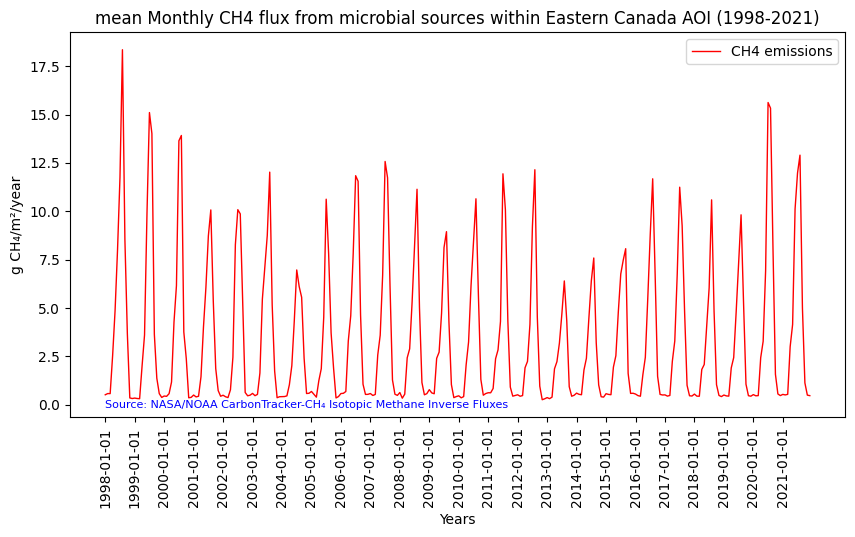

In [32]:
# Figure size: 20 representing the width, 10 representing the height
df = df.sort_values(by="datetime")
fig = plt.figure(figsize=(10,5))

# Change 'which_stat' below if you would rather look at a different statistic, like minimum or mean.
which_stat = "mean"

plt.plot(
    df["datetime"], # X-axis: sorted datetime
    df[which_stat], # Y-axis: maximum CH4 flux
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=1, # Line width
    label="CH4 emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("g CH₄/m²/year")
plt.xticks(rotation = 90)

interval = 12
ticks = range(0, len(df), interval)  # Tick positions
plt.xticks(ticks, df["datetime"].iloc[ticks])  # Use the corresponding datetime values


# Insert title for the plot
plt.title(f"{which_stat} Monthly CH4 flux from {asset_name} sources within {aoi_name} AOI (1998-2021)")

# Add data citation
plt.text(
    df["datetime"].iloc[0],           # X-coordinate of the text
    df[which_stat].min(),                  # Y-coordinate of the text

    # Text to be displayed
    "Source: NASA/NOAA CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes",                  
    fontsize=8,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)


# Plot the time series
plt.show()

This is a visual representation of the seasonal cycle of microbial methane emissions in Eastern Canada over the span of 22 years!

## Summary

In this notebook we have successfully completed the following steps for the STAC collection for the CarbonTracker-CH₄ Isotopic Methane Inverse Fluxes dataset:
1.	Install and import the necessary libraries 
2.	Fetch the collection from STAC collections using the appropriate endpoints
3.	Count the number of existing granules within the collection
4.	Map and compare the CH₄ inverse fluxes over an area of interest for two distinctive dates/times
5.	Create a table that displays the minimum, maximum, and sum of the CH₄ inverse fluxes for a specified region
6.	Generate a time-series graph of the CH₄ inverse fluxes for a specified region

If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform). 